In [85]:
import matplotlib.pyplot as plt
import numpy as np



hbar=1
m=1

plt.rc('figure', figsize=[13,7]) #Diagramm size

def V(x,v): #Potential "inf quantum well"
    if abs(x)>1:
        return v
    else:
        return 0
    

    
def I1(s,e,n): #Intervall for \Psi started at s ended at e with n steps
    x = (e-s)/(n)
    Y = []
    for z in range(n-1):
        Y.append(s+(z+1)*x)
    return Y


def I2(s,e,n): #Intervall for V started at s ended at e with n steps
    x = (e-s)/(n-1)
    Y = []
    for z in range(n):
        Y.append(s+z*x)
    return Y

def H(s,e,n,v,E=0): #Matrix
    X = np.zeros((n-1,n-1))
    Y = L(s,e,n)
    for z in range(n-1):
        X[z,z] = (hbar**2)/m/(((e-s)/n)**2)+V(Y[z],v)-E
    for z in range(n-2):
        X[z,z+1]=-(hbar**2)/m/(((e-s)/n)**2)/2
        X[z+1,z]=-(hbar**2)/m/(((e-s)/n)**2)/2
    return X 

def E(n):#analytic E
    F = [] 
    for x in range(n-2):
        F.append(np.pi**2/8*(x+1)**2)
    return F

def f(x,E): #analytic eigenfunction (not normalized)
    k = np.sqrt(2*m*E)/(hbar**2)
    return np.sin(k*(x+1))

def X(n): #x-values for plot
    Y = []
    for x in range(n-2):
        Y.append(x+1)
    return Y


def PlotNumerov(sPsi,ePsi,nPsi,sV,eV,nV,v=0, w=0,nP=0): 
#v=1:show number of bound states, w=1: plot analytic functions, nP: number of eigenfunction-plots
    A = []
    Z = []
    B = I1(sPsi,ePsi,nPsi)
    C = I2(sV,eV,nV)
    D = []
    F = []
    G = []
    I = []
    J = []
    K = []
    O = []
    P = []
    R = []
    T = np.array(I2(-1,1,100))
    for x in range(nV):
        a=np.linalg.eig(H(sPsi,ePsi,nPsi,C[x]))
        l=0
        for y in range(nPsi-1):
            if a[0][y]<C[x]:
                l += 1
        Z.append(l)
        if v==1:
            print("For V=%f are %d Eigenvalues below V (%d/%d)" %(C[x], l, x+1, nV))
    k=0
    for x in range(nV):
        if Z[x] == max(Z):
            k=x
    a=np.linalg.eig(H(sPsi,ePsi,nPsi,C[k]))
    for x in range(nPsi-2):
        if a[0][x]<C[k]:
            J.append([a[0][x],a[1][:,x]])
    K = J.sort(key=lambda x: x[0])
    D=X(l+2)
    G=E(l+2)
    for x in range(l):
        F.append(J[x][0])
    for x in range(l):
        I.append(abs(F[x]-G[x])/G[x]*100)
    if v==1:    
        print("Choose V=%f:"%C[k])
        print("")
        print("")
    plt.plot(D,F,c='r')
    plt.plot(D,G,c='b')
    plt.xlabel('n')
    plt.ylabel('E')
    plt.legend(["Numeric $E_n$","Analytic $E_n$"],loc="upper left")
    plt.title("Numeric $E_n$ vs. Analytic $E_n$")
    plt.show()
    print("")
    plt.plot(D,I,c='k')
    plt.title("Relative error")
    plt.xlabel('n')
    plt.ylabel('%')
    plt.show()
    if nP != 0:
        l = min(nP,l)
    for x in range(l):
        print("")
        if w==0:
            plt.plot(B,J[x][1],c='k')
        if w==1:
            maxA = f(T[0],G[x])
            maxAn = 0
            maxNn = 0
            for r in range(100):
                if abs(maxA)<abs(f(T[r],G[x])):
                    maxA = f(T[r],G[x])
                    maxAn = r
            while T[maxAn]>B[maxNn]:
                maxNn += 1
            maxN = J[x][1][maxNn]
            plt.plot(B,J[x][1],c='r')
            plt.plot(T,maxN/maxA*f(T,G[x]),c='b',alpha=0.5)
            plt.legend(["Numeric $\Psi_%d$" %(x+1),"Analytic $\Psi_%d$" %(x+1)],loc="upper left")
        plt.xlim(-1,1)
        plt.xlabel('x')
        plt.title("Eigenfunction for $E_{%d}$ = %.2f $\pm$ %d %%" %(x+1,J[x][0],I[x]))
        plt.show()

#................................................... worke in progress
#................................................... worke in progress
#................................................... worke in progress


hbar=1
m=1
g=1
mub=1
mu=1


def V1(x):
    return hbar**2/m/(x**2)/2
  

def V2(b):
    return g*mub*b


def V3(x,a=1):
    return a/2/x




def H2(s,e,n,b=1,E=0): #Matrix only psi1 and psi2
    X = np.zeros((2*n-2,2*n-2))
    Y = I1(s,e,n)
    for z in range(n-1):
        X[z,z] = 2*V1((e-s)/n)+V2(b)-E #1-psi1
        X[z+n-1,z+n-1] = 2*V1((e-s)/n)-V2(b)-E #2-psi2
    for z in range(n-2):
        X[z,z+1]=-V1((e-s)/n) #1-psi1
        X[z+1,z]=-V1((e-s)/n) #1-psi1
        X[z,z+n]=V3((e-s)/n) #1-psi2
        X[z+1,z+n-1]=-V3((e-s)/n) #1-psi2
        X[z+n-1,z+1+n-1]=-V1((e-s)/n) #2-psi2
        X[z+1+n-1,z+n-1]=-V1((e-s)/n) #2-psi2
        X[z+n,z]=V3((e-s)/n) #2-psi1
        X[z+n-1,z+1]=-V3((e-s)/n) #2-psi2
    return X 


def PlotE2(s,e,n):
    s=H2(s,e,n)
    t=np.linalg.eig(s)
    x = np.linspace(-1,1,10)
    for m in range(2*n-2):
        y = []
        for n in range(10):
            y.append(t[0][m])
        plt.plot(x,y)
    plt.show()
    



def H3(s,e,n,b=1,a=1,d=1,mu=1,E=0): #BdG
    X = np.zeros((4*n-4,4*n-4))
    Y = I1(s,e,n)
    for z in range(n-1):
        X[z,z] = 2*V1((e-s)/n)+V2(b)-mu-E #1-psi1
        X[z,z+2*n-2]=d #1-psi3
        X[z+n-1,z+n-1] = 2*V1((e-s)/n)-mu-V2(b)-E #2-psi2
        X[z+n-1,z+3*n-3] = d #2-psi4
        X[z+2*n-2,z+2*n-2] = -2*V1((e-s)/n)+mu+V2(b)-E #3-psi3
        X[z+2*n-2,z] = d #3-psi1
        X[z+3*n-3,z+3*n-3] = -2*V1((e-s)/n)+mu-V2(b)-E #4-psi4
        X[z+3*n-3,z+n-1] = d #4-psi2
    for z in range(n-2):
        X[z,z+1]=-V1((e-s)/n) #1-psi1
        X[z+1,z]=-V1((e-s)/n) #1-psi1
        X[z,z+n]=V3((e-s)/n,a) #1-psi2
        X[z+1,z+n-1]=-V3((e-s)/n,a) #1-psi2
        X[z+n-1,z+1+n-1]=-V1((e-s)/n) #2-psi2
        X[z+1+n-1,z+n-1]=-V1((e-s)/n) #2-psi2
        X[z+n,z]=V3((e-s)/n,a) #2-psi1
        X[z+n-1,z+1]=-V3((e-s)/n,a) #2-psi2
        X[z+2*n-2,z+1+2*n-2]=V1((e-s)/n) #3-psi3
        X[z+1+2*n-2,z+2*n-2]=V1((e-s)/n) #3-psi3
        X[z+2*n-1,z+3*n-3]=-V3((e-s)/n,a) #3-psi4
        X[z+2*n-2,z+3*n-2]=V3((e-s)/n,a) #3-psi4
        X[z+3*n-3,z+1+3*n-3]=V1((e-s)/n) #4-psi4
        X[z+1+3*n-3,z+3*n-3]=V1((e-s)/n) #4-psi4
        X[z+3*n-2,z+2*n-2]=V3((e-s)/n,a) #4-psi3
        X[z+3*n-3,z+2*n-1]=-V3((e-s)/n,a) #4-psi3
    return X

#print(H3(-5,5,3))

def PlotE3(s,e,n,b,a,d,mu):
    s=H3(s,e,n,b,a,d,mu)
    t=np.linalg.eig(s)
    x = np.linspace(-1,1,10)
    e = 0
    for m in range(4*n-4):
        y = []
        for n in range(10):
            y.append(t[0][m])
        if abs(t[0][m])<0.01:
            print("E=%f (Eigenvalue number %d)" %(t[0][m], m))
            e += 1
        plt.plot(x,y, 'b')
    print("%d Energies around zero" %e)
    plt.show()
    print("")
    print("...........")


# Numerov method for infinite potential well

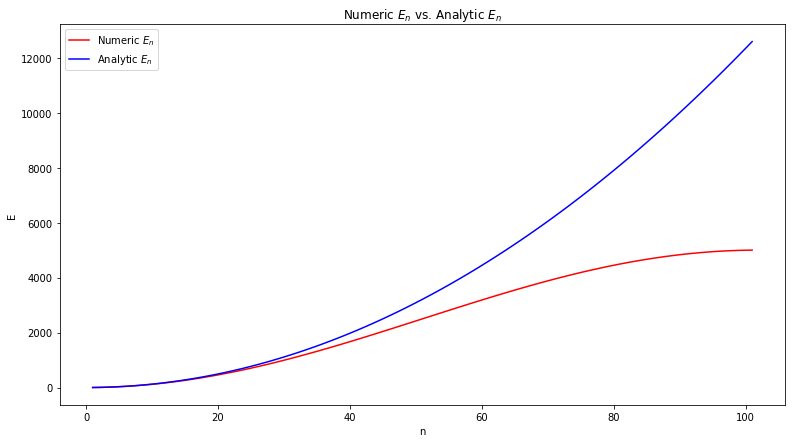

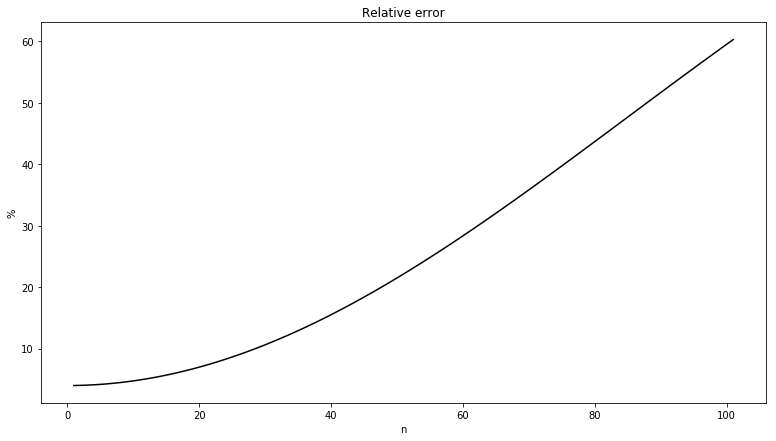

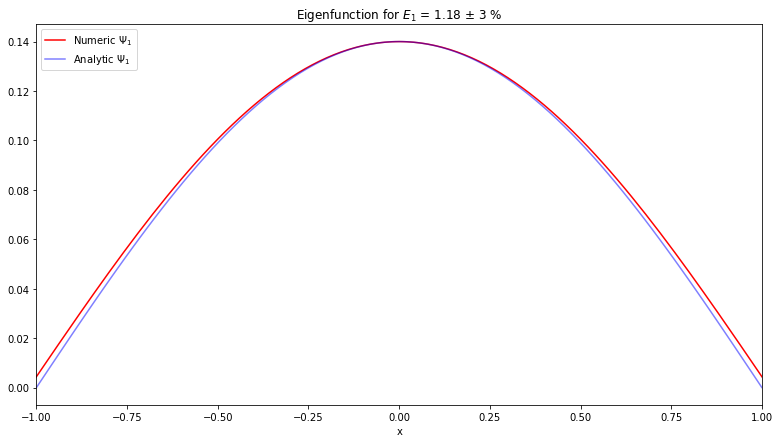

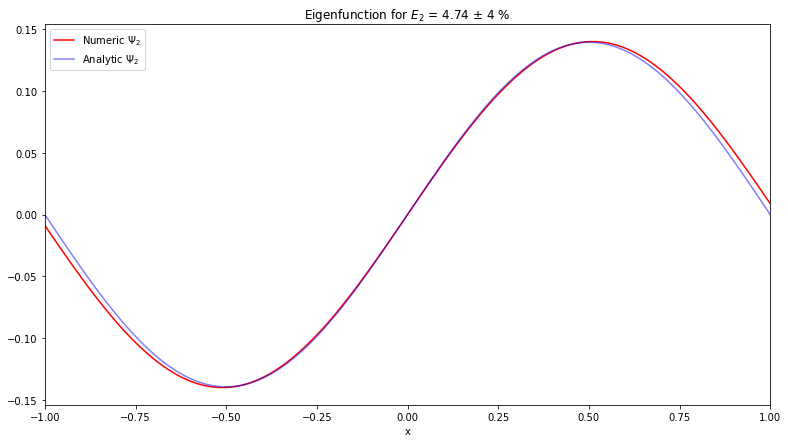

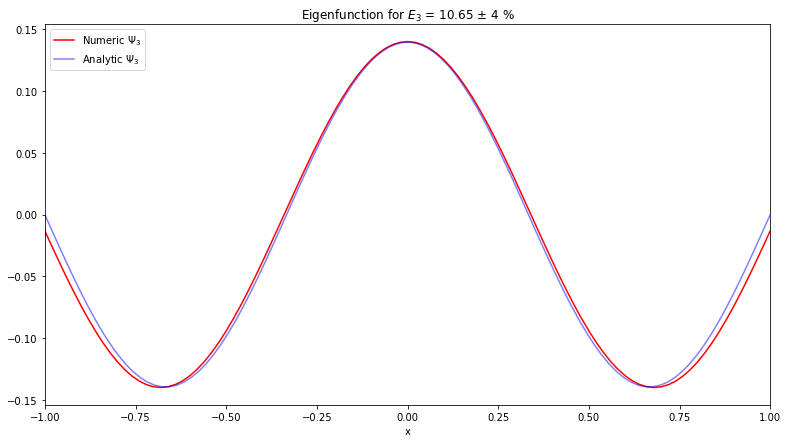

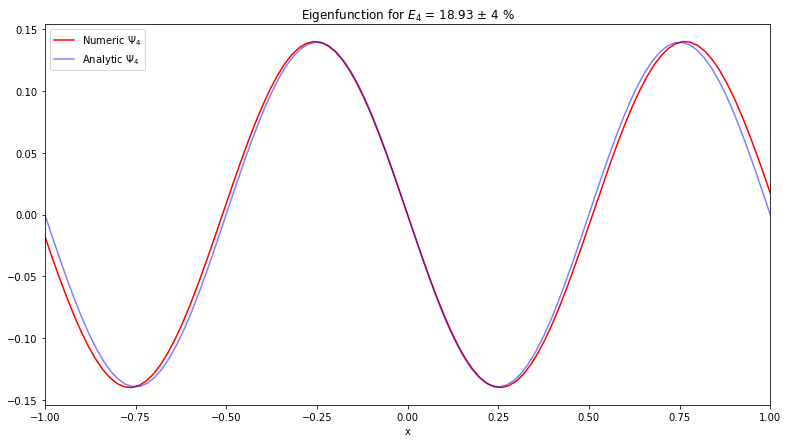

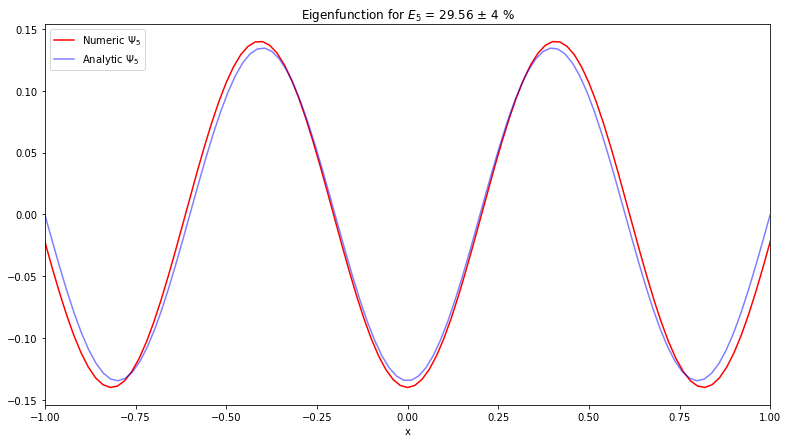

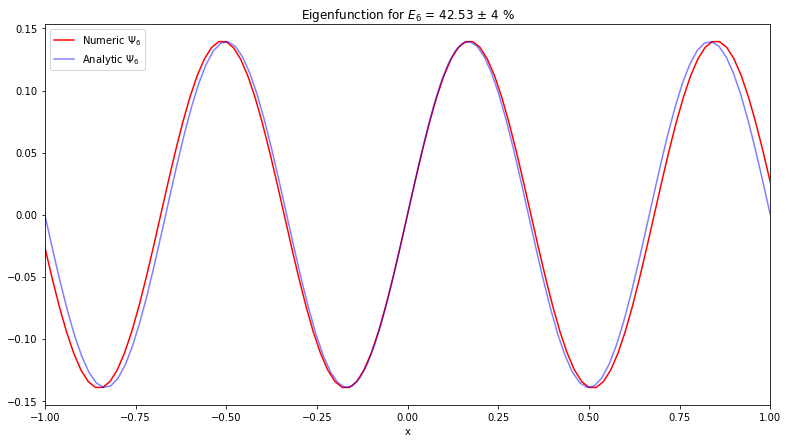

In [81]:
PlotNumerov(-5,5,500,50,50000,2,w=1, nP=6)

# Numerov method for Bogoliubov-de Gennes Hamiltonian

0 Energies around zero


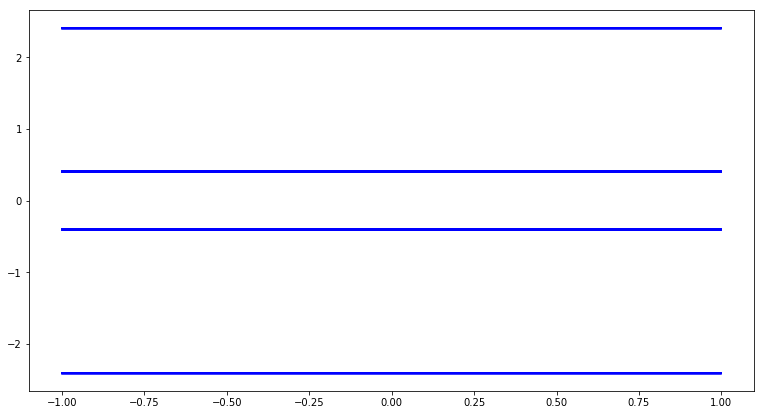


...........
0 Energies around zero


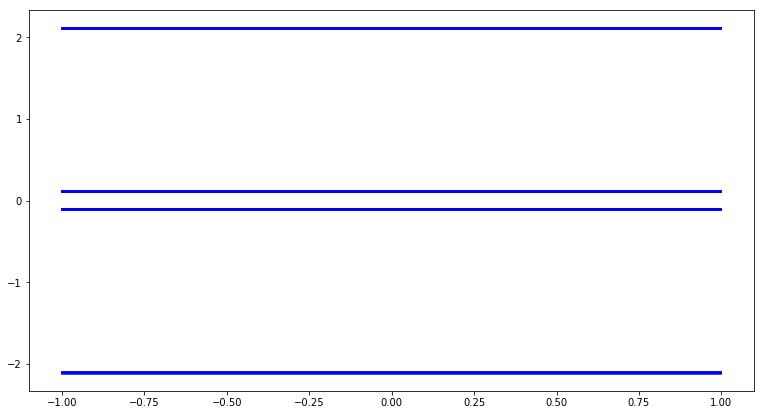


...........
E=0.000846 (Eigenvalue number 0)
E=0.003210 (Eigenvalue number 1)
E=0.006613 (Eigenvalue number 2)
E=-0.000846 (Eigenvalue number 27)
E=-0.003210 (Eigenvalue number 28)
E=-0.006613 (Eigenvalue number 29)
6 Energies around zero


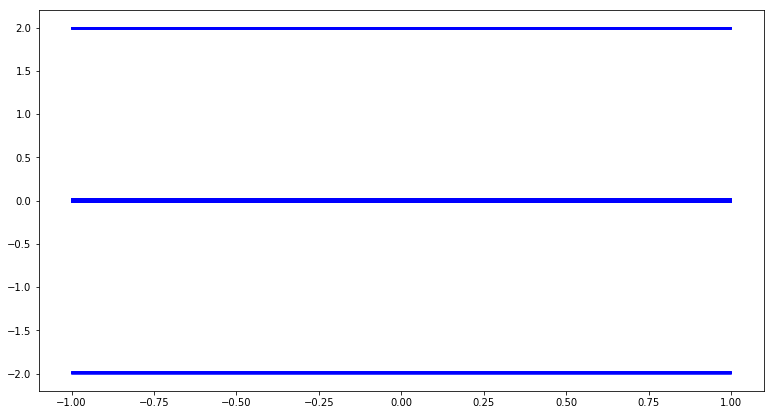


...........
0 Energies around zero


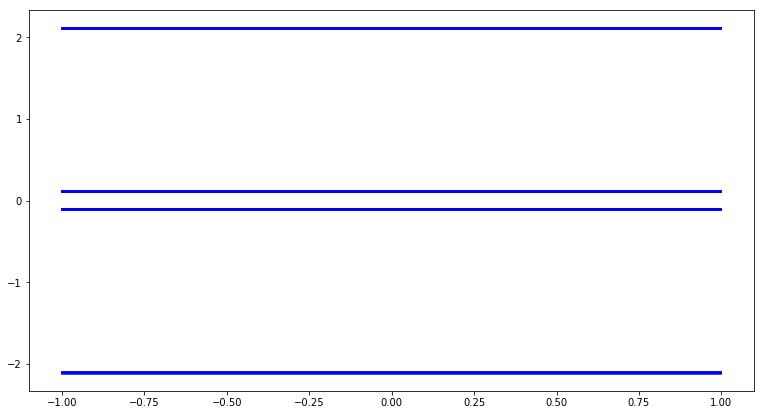


...........
0 Energies around zero


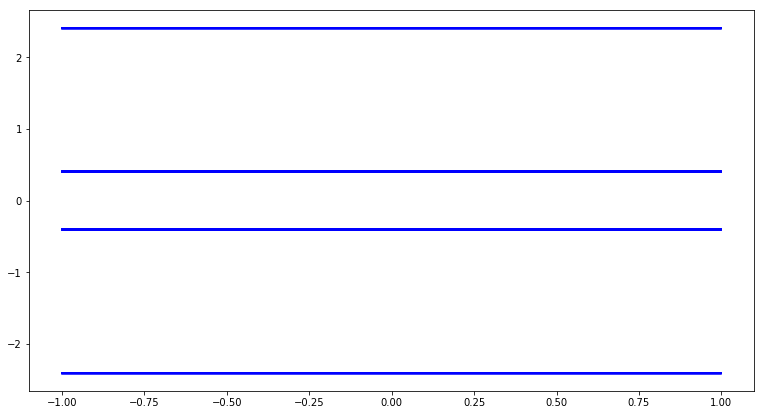


...........


In [88]:
#................................................... worke in progress
#................................................... worke in progress
#................................................... worke in progress
for x in range(5):
    PlotE3(-50,50,10,1,1,-1+0.5*x,1)